In [162]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import statsmodels.api as sm
import pytensor.tensor as pt
from pytensor import function
from pytensor.printing import Print
import seaborn as sns
import jax
import blackjax
import numpyro
import pymc.sampling.jax as pmjax
import tensorflow as tf
import preliz as pz

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

In [163]:

settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5, 
            'figure.constrained_layout.use':True}
plt.rcParams.update(settings)

In [164]:
# get data     
data = pd.read_csv(r"../data/a0_combinedQuarterly_new.csv", index_col=[0])
data = data['gdp_total_season'].to_frame()
data['gdp_total_season_diff'] = data['gdp_total_season'].diff()
data.dropna(inplace=True)


In [165]:
data

,gdp_total_season,gdp_total_season_diff
1995-04-01,116624.0,-14.0
1995-07-01,114315.0,-2309.0
1995-10-01,121939.0,7624.0
1996-01-01,119460.0,-2479.0
1996-04-01,121240.0,1780.0
...,...,...
2023-01-01,197186.0,-10443.0
2023-04-01,206848.0,9662.0
2023-07-01,196434.0,-10414.0
2023-10-01,206850.0,10416.0


            gdp_total_season  gdp_total_season_diff  \
1995-04-01          116624.0                  -14.0   
1995-07-01          114315.0                -2309.0   
1995-10-01          121939.0                 7624.0   
1996-01-01          119460.0                -2479.0   
1996-04-01          121240.0                 1780.0   
...                      ...                    ...   
2023-01-01          197186.0               -10443.0   
2023-04-01          206848.0                 9662.0   
2023-07-01          196434.0               -10414.0   
2023-10-01          206850.0                10416.0   
2024-01-01          195724.0               -11126.0   

            gdp_total_season_diff_stdz  gdp_total_season_stdz  
1995-04-01                   -0.103615              -2.118720  
1995-07-01                   -0.445386              -2.223228  
1995-10-01                    1.033835              -1.878156  
1996-01-01                   -0.470702              -1.990359  
1996-04-01         

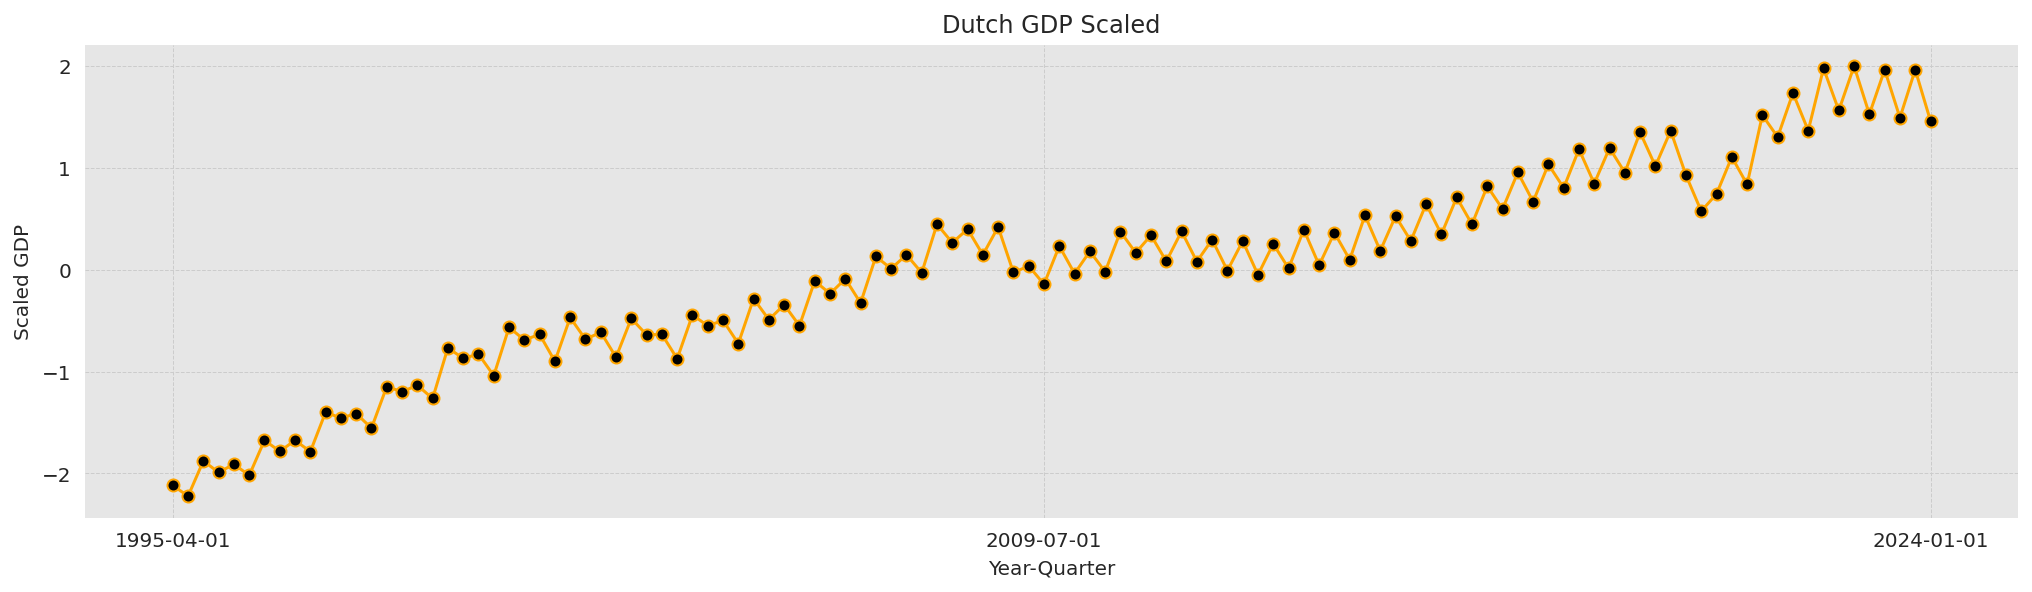

In [166]:
scaler = StandardScaler()

data['gdp_total_season_diff_stdz'] = scaler.fit_transform(data[["gdp_total_season_diff"]])
data['gdp_total_season_stdz'] = scaler.fit_transform(data[["gdp_total_season"]])
plt.plot(data.index, data['gdp_total_season_stdz'], 'o-', color='orange',  markerfacecolor='black')
ticks = ['1995-04-01', '2009-07-01', '2024-01-01']
plt.xticks(ticks)
plt.title("Dutch GDP Scaled")
plt.ylabel("Scaled GDP")
plt.xlabel("Year-Quarter")
y = data
plt.savefig("../figures/GDPStandardized.png")

print(y)

In [167]:
y = data["gdp_total_season"].to_numpy()
y_max = np.max(y)
y = y / y_max
data["gdp_total_season_stdz"] = y

In [168]:
x_train = np.arange(1, len(data.index)+1)[:,None]
y_train = data['gdp_total_season_stdz'].values

In [169]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.95, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [170]:
numpyro.set_host_device_count(4)
with pm.Model() as model:

    # Seasonal component
    ls_1 = pm.InverseGamma('ls_1', **get_ig_params(x_train))
    period_1 = pm.Gamma(name='period_1', alpha=1.0, beta=3.0)
    gp_1 = pm.gp.Marginal(cov_func=pm.gp.cov.Periodic(input_dim=1, period=period_1, ls=ls_1))

    # Second seasonal component
    ls_2 = pm.InverseGamma('ls_2', **get_ig_params(x_train))
    period_2 = pm.Gamma(name='period_2', alpha=1.0, beta=10.0)
    gp_2 = pm.gp.Marginal(cov_func=pm.gp.cov.Periodic(input_dim=1, period=period_2, ls=ls_2))

    # Linear trend
    c_3 = pm.Normal(name='c_3', mu=1, sigma=2)
    gp_3 = pm.gp.Marginal(cov_func=pm.gp.cov.Linear(input_dim=1, c=c_3))
    
    # Define gaussian process
    gp = gp_1 + gp_2 + gp_3
    
    # Noise
    sigma = pm.HalfNormal(name='sigma', sigma=10)
    
    # Likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=x_train, y=y_train, sigma=sigma)
    
    # Sample.
    trace = pmjax.sample_numpyro_nuts(draws=1000, chains=2, chain_method = "parallel", postprocessing_backend="gpu")
    

/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 2000/2000 [16:10<00:00,  2.06it/s, 127 steps of size 1.00e-02. acc. prob=0.98]
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [171]:
with model:
    f_pred = gp.conditional('f_pred', x_train)

In [172]:
with model:
    idata_reg_subset = trace.sel(draw=slice(0, None, 100))
    pred_samples = pm.sample_posterior_predictive(idata_reg_subset,
                                                  var_names=["f_pred"])

Sampling: [f_pred]


Output()

In [173]:
f_pred = (pred_samples.
          posterior_predictive.stack(samples=("chain", "draw"))['f_pred'].
          values)

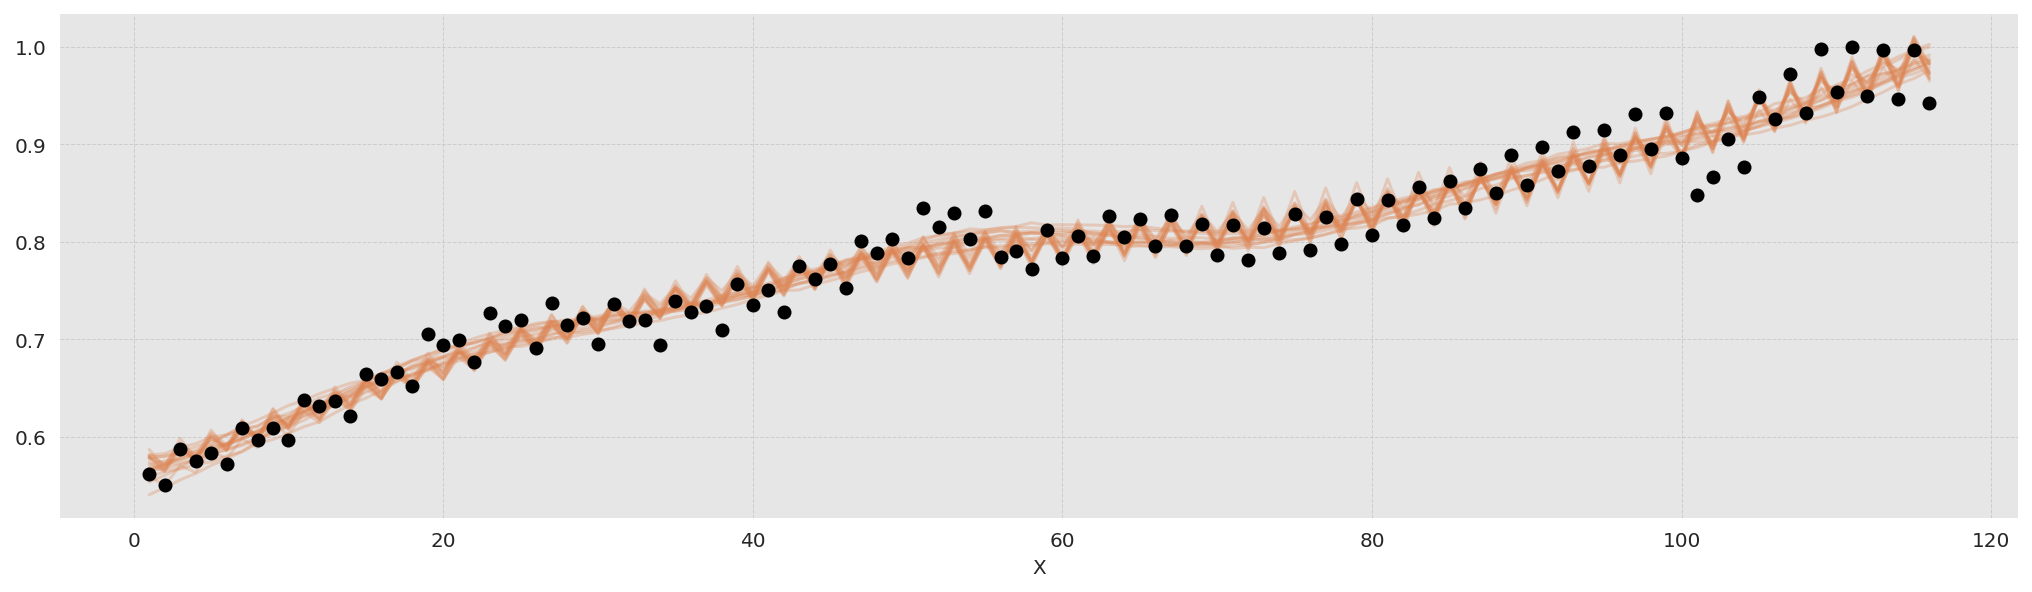

In [174]:
_, ax = plt.subplots()
ax.plot(x_train, f_pred, 'C1-', alpha=0.3)
ax.plot(x_train, y_train, 'ko')
ax.set_xlabel('X')
plt.savefig('tmp_GP_sd_fit_lines.png')

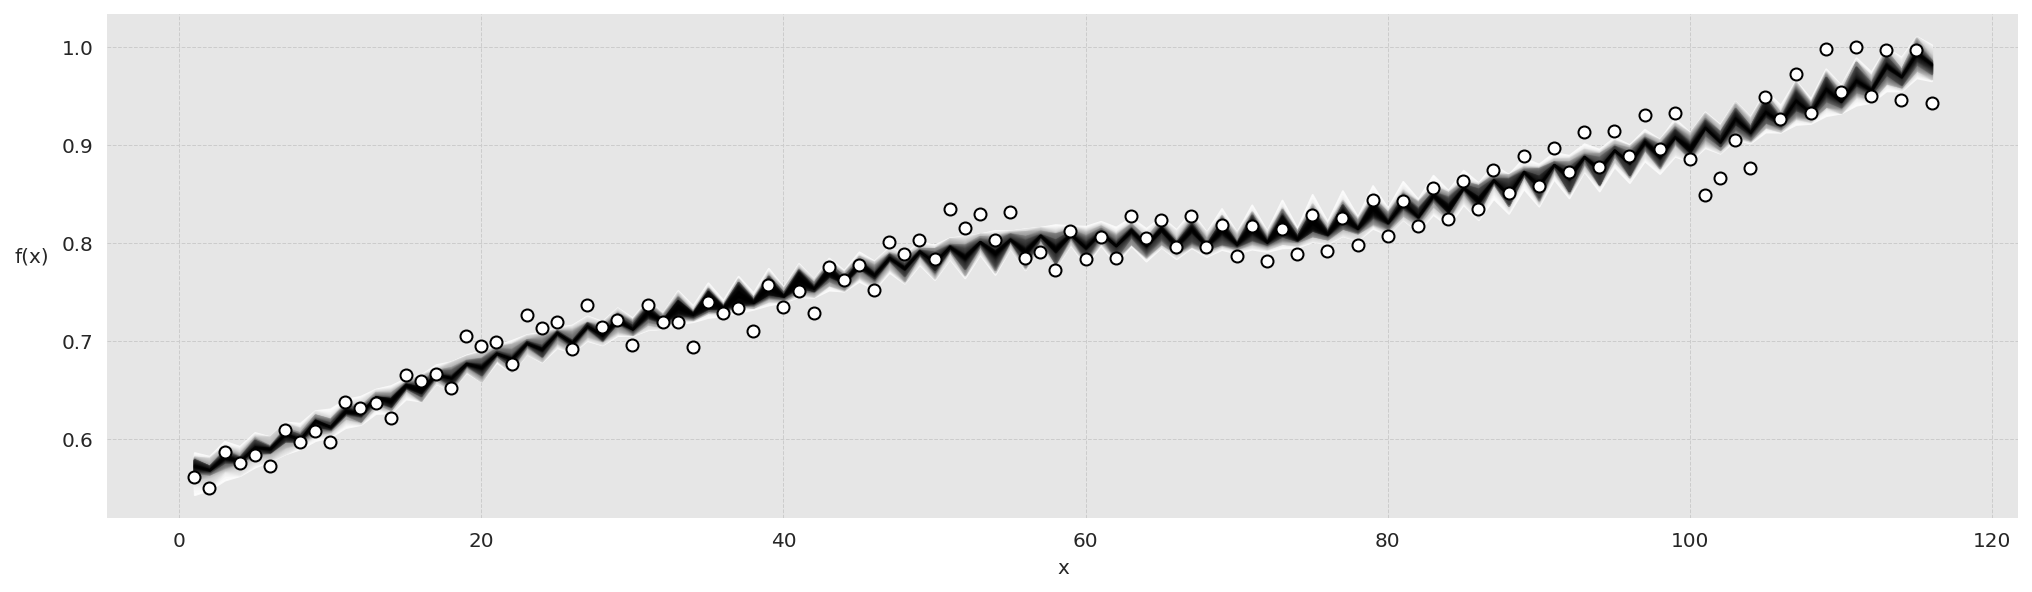

In [175]:
_, ax = plt.subplots()

pm.gp.util.plot_gp_dist(ax, f_pred.T, x_train, palette='gray_r', plot_samples=False);

ax.plot(x_train, y_train, 'wo', mec='k')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)
plt.savefig('GP_sd_fit_dist.png')

In [176]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

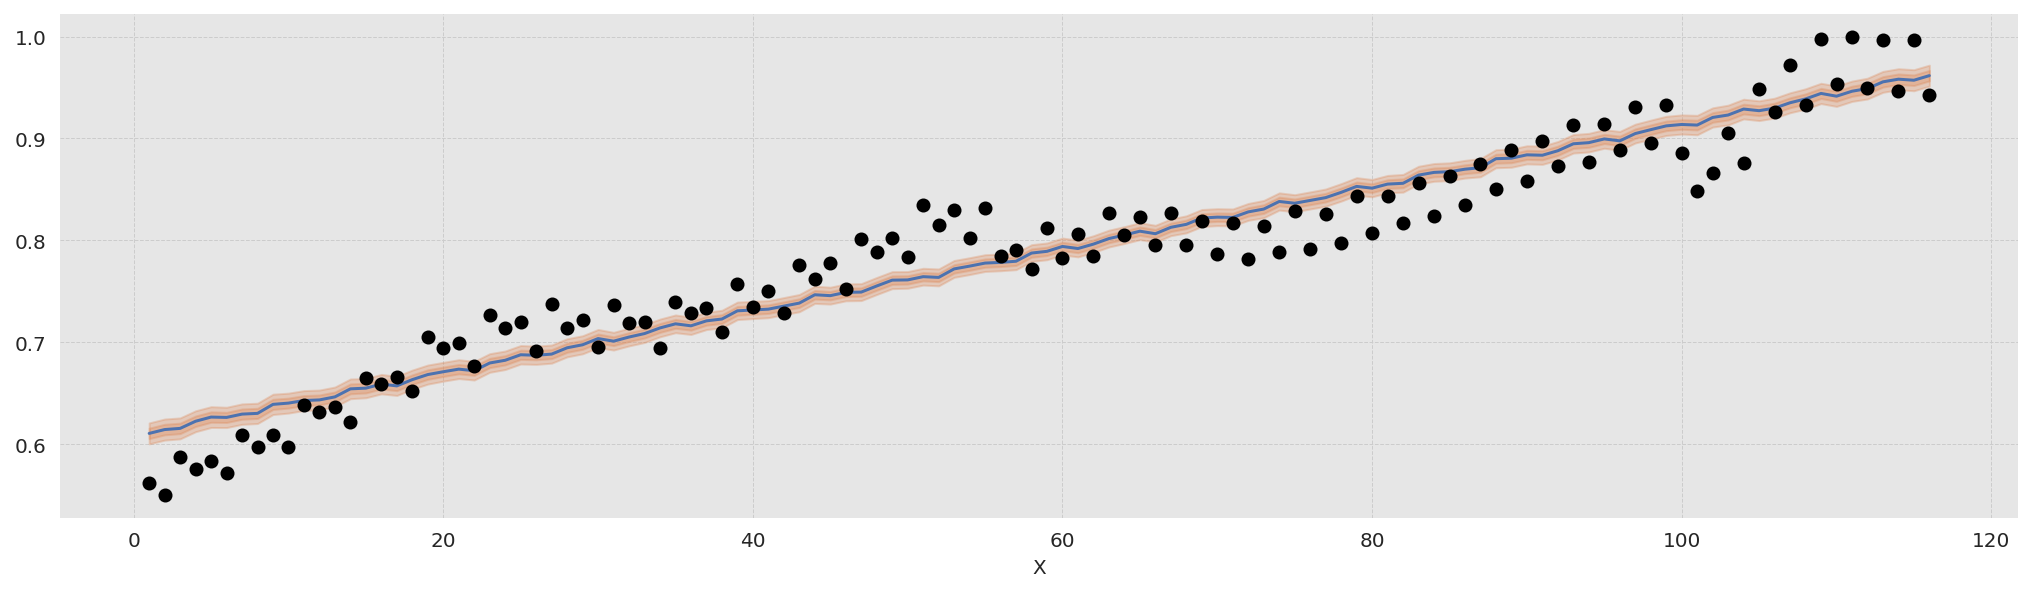

In [177]:
# plot the results
_, ax = plt.subplots()

# predict
point = {'ls_1': trace.posterior['ls_1'].mean(), 'sigma': trace.posterior['sigma'].mean(),  'period_2': trace.posterior['period_2'].mean(),  'c_3': trace.posterior['c_3'].mean(), 'ls_2': trace.posterior['ls_2'].mean(), 'period_1': trace.posterior['period_1'].mean(),}
mu, var = gp.predict(x_train, point=point, diag=True,  model=model)
sd = var**0.5

# plot mean and 1σ and 2σ intervals
ax.plot(x_train, mu, 'C0')
ax.fill_between(x_train.flatten(),
                 mu - sd, mu + sd,
                 color="C1",
                 alpha=0.3)

ax.fill_between(x_train.flatten(),
                 mu - 2*sd, mu + 2*sd,
                 color="C1",
                 alpha=0.3)

ax.plot(x_train, y_train, 'ko')
ax.set_xlabel('X')
plt.savefig('GP_sd_fit_bands.png')